In [30]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import copy
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import scipy.stats as stats

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

import hdp_scripts as hdp
import multivariate_normal
import classification_evaluation as hdp_eval
import data_generation as gen
import imp # for reloading a local script
import time
imp.reload(multivariate_normal)
from multivariate_normal import MultivariateNormal
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

<module 'data_generation' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/data_generation.py'>

# Index:
- [Basic unit tests](#1)
- [Running a 1D AR(1) test](#2)
- [Running a multidimensional AR(1) test](#3)
- [Running a 1D AR(2) test](#4)
- [Running a multidimensional SLDS test](#5)

<a id=1></a>
# Test the MVN class
I just test the vectorised output of the MultivariateNormal Class to ensure that it is the same as the statsmodels equivalent.

In [31]:
# print(stats.multivariate_normal(np.zeros(2), np.eye(2)).logpdf(0.2*np.ones(2)))
print(MultivariateNormal(np.ones(2), np.eye(2)).logpdf(0.2*np.ones(2)))
print(MultivariateNormal([np.ones(2) for i in range(2)], [np.eye(2) for i in range(2)]).logpdf(0.2*np.ones(2)))
print(MultivariateNormal([[np.ones(2) for i in range(2)] for j in range(2)], [[np.eye(2) for i in range(2)] for j in range(2)]).logpdf(0.2*np.ones(2)))

-2.4778770664093455
[-2.47787707 -2.47787707]
[[-2.47787707 -2.47787707]
 [-2.47787707 -2.47787707]]


<a id=2></a>
# 1D AR(1) Test (based on Gharamani and Hinton)

In [32]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

<module 'data_generation' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/data_generation.py'>

#### Generate the data

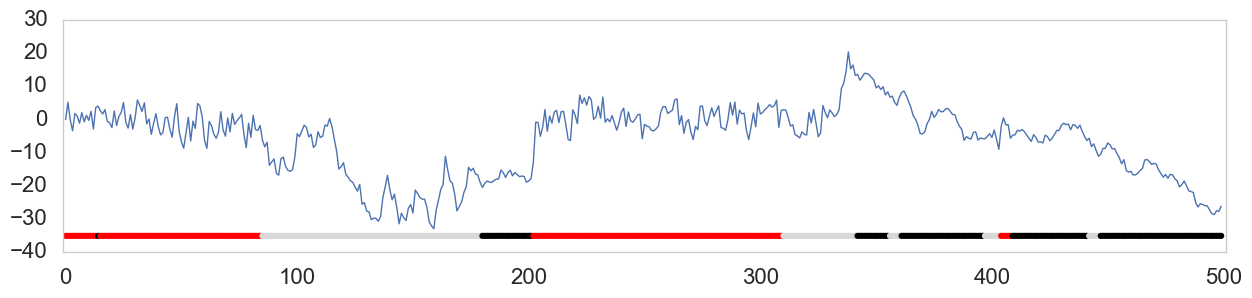

In [51]:
length = 500
chain_params = [{"A": 0.99, "sigma": 2}, {"A": 0.99, "sigma": 10}, {"A": 0.5, "sigma": 10}]
res = gen.generate_data_1D(num_chains=len(chain_params), length=length, switch_prob=0.05, chain_params=chain_params)
chains, Y = res['chains'], res['Y'][:,0]

fig, ax = plt.subplots(figsize=(15,3))
temp = np.arange(0,length,1)

c=['black','#d8d8d8', 'r', 'g', 'b', 'y', '#42e5f4', '#42e5f4', '#f47a41', 'blue',
  '#597757', '#576977', '#635777', '#635777', '#0FF000']

plt.scatter(temp, -35*np.ones_like(temp), c=[c[i] for i in chains], lw=0)
plt.plot(Y, lw=1, alpha=1)
plt.xlim([-1,length+1])
plt.grid(False)

#### Run the inference - AR(1) model

In [52]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

params = {}
L = 10
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[np.random.normal(1,1)]]), 'sigma': np.array([[10]])} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = .1*len(Y)
params['gamma'] = 1
params['priors'] = {
    'M': 0*np.eye(D),
    'K': 1*np.eye(D)
}

params, res, assignments, _ = hdp.sticky_HDP_AR(Y, params, priors=[np.cov(Y.T)*0.75, D+2],
                                             num_iter=100,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

Iteration: 0, # inf chain: 10, time: 1.49, hamming_dist: 369.000
Iteration: 10, # inf chain: 4, time: 1.29, hamming_dist: 30.000
Iteration: 20, # inf chain: 3, time: 1.17, hamming_dist: 61.000
Iteration: 30, # inf chain: 3, time: 1.16, hamming_dist: 86.000
Iteration: 40, # inf chain: 4, time: 1.29, hamming_dist: 62.000
Iteration: 50, # inf chain: 3, time: 1.24, hamming_dist: 54.000
Iteration: 60, # inf chain: 4, time: 1.16, hamming_dist: 80.000
Iteration: 70, # inf chain: 3, time: 1.18, hamming_dist: 55.000
Iteration: 80, # inf chain: 5, time: 1.16, hamming_dist: 72.000
Iteration: 90, # inf chain: 4, time: 1.29, hamming_dist: 54.000


#### Visualization of results

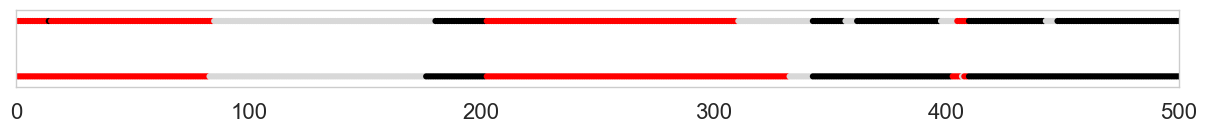

In [53]:
res = np.median(assignments[:,assignments.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

plt.figure(figsize=(15,1))
plt.scatter(np.linspace(0,len(res),num=len(res)), 1.5*np.ones_like(res), c=[c[i] for i in seq2_updated], lw=0)
plt.xlim([0,len(res)])
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(res)])

plt.yticks([])
plt.grid(False)

<a id=3></a>
# Now multivariate AR(1) model:
Now we actually get into the project. Test the AR(1) generation of data and test how well the three models are able to recover the labels. 

#### Generate the data

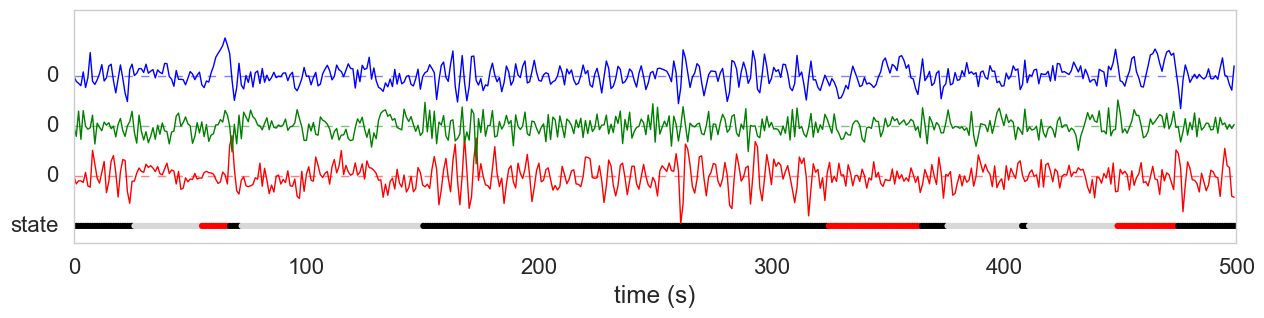

In [36]:
def generateTransitionMatrix(dim):
    A = stats.matrix_normal(mean=np.zeros((dim,dim)), rowcov=0.4*np.eye(dim), colcov=0.4*np.eye(dim)).rvs()  #+ 40*np.eye(dim) + 40*waterfall
    return A

def generateCovMatrix(dim, M, scale, reg):
    noise_cov = stats.invwishart(scale=scale*np.eye(3), df=20).rvs()
    return noise_cov


Y = np.array([0,0,0]) # there are three observables
dim = 3

length = 500
chain_params = [{"A": generateTransitionMatrix(dim), "sigma": 1*np.eye(dim)}, 
                {"A": generateTransitionMatrix(dim), "sigma": 1*np.eye(dim)}, 
                {"A": generateTransitionMatrix(dim), "sigma": 1*np.eye(dim)}]

res = np.zeros(shape=(length,3))
k=0
chains=[k]

for t in range(1,length):
    if np.random.binomial(n=1,p=0.02) == 1:
        k = np.random.choice(np.arange(dim).astype(np.int8), p=np.ones(dim)/dim)
    chains.append(k)
    res[t] = np.random.multivariate_normal(mean=chain_params[k]['A'].dot(res[t-1]), cov=chain_params[k]['sigma'])

# res = gen.generate_data_nD(dim=3, num_chains=len(chain_params), length=length, switch_prob=0.02, chain_params=chain_params)
# chains, Y = res['chains'], res['Y']
# chains = np.zeros(shape=length).astype(np.int16)
Y = res

plt.figure(figsize=(15,3))

plt.plot(Y[:,0], lw=1, c='r')
plt.plot(np.ones_like(Y[:,0])*0, lw=1, c='r', alpha=0.5, ls='--')
plt.plot(Y[:,1] + 7.5, lw=1, c='g')
plt.plot(np.ones_like(Y[:,0])*7.5, lw=1, c='g', alpha=0.5, ls='--')
plt.plot(Y[:,2] + 15, lw=1, c='b')
plt.plot(np.ones_like(Y[:,0])*15, lw=1, c='b', alpha=0.5, ls='--')

plt.scatter(np.linspace(0,len(chains),num=len(chains)), -7.5*np.ones_like(chains), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(chains)])
plt.yticks([-7.5,0,7.5,15],('state','0','0','0'))
plt.xlabel('time (s)')

plt.grid(False)

#### Run the inference

In [37]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

L = 10
D = 3
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
# params['theta'] = [{'A': generateTransitionMatrix(D), 'sigma': 5*np.eye(D)} for i in range(L)]
params['theta'] = [{'A': generateTransitionMatrix(D), 'sigma': generateCovMatrix(3, np.zeros(shape=(dim, dim)),2 ,5)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 0.1*len(Y)
params['gamma'] = 1
params['priors'] = {
    'M': np.zeros(shape=(D, D)),
    'K': np.eye(D)
}

params, res, assignments_ar1, _ = hdp.sticky_Multi_HDP_AR(Y, params, priors=[np.cov(Y.T)*.75, D+2],
                                                         num_iter=100,
                                                         return_assignments=True,
                                                         verbose=True,
                                                         chains=chains)

Iteration: 0, # inf chain: 10, time: 1.63, hamming_dist: 358.000
Iteration: 10, # inf chain: 6, time: 1.54, hamming_dist: 165.000
Iteration: 20, # inf chain: 4, time: 1.35, hamming_dist: 98.000
Iteration: 30, # inf chain: 4, time: 1.52, hamming_dist: 53.000
Iteration: 40, # inf chain: 4, time: 1.51, hamming_dist: 29.000
Iteration: 50, # inf chain: 3, time: 1.56, hamming_dist: 19.000
Iteration: 60, # inf chain: 4, time: 1.55, hamming_dist: 35.000
Iteration: 70, # inf chain: 4, time: 1.56, hamming_dist: 26.000
Iteration: 80, # inf chain: 3, time: 1.56, hamming_dist: 33.000
Iteration: 90, # inf chain: 3, time: 1.43, hamming_dist: 23.000


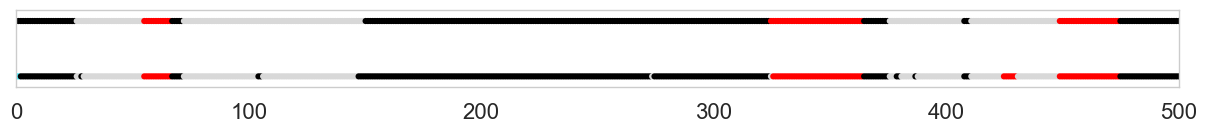

In [38]:
res = np.median(assignments_ar1[:,assignments_ar1.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

plt.figure(figsize=(15,1))
plt.scatter(np.linspace(0,len(res),num=len(res)), 1.5*np.ones_like(res), c=[c[i] for i in seq2_updated], lw=0)
plt.xlim([0,len(res)])
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(res)])

plt.yticks([])
plt.grid(False)

#### Inference with AR(2) Model

In [39]:
chain_params[0]

{'A': array([[ 0.27454481,  0.13390817,  1.04112488],
        [-0.42113151, -0.66658648,  0.26582277],
        [-0.58251982, -0.37172686,  0.49639059]]),
 'sigma': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])}

In [40]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

params = {}
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([np.array(np.eye(D)), np.array(np.eye(D))]),
                    'sigma': 1*np.array(np.eye(D))} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = .1*len(Y)
params['gamma'] = 1
params['priors'] = {
    # need to adjust the priors slightly
    'M': np.zeros(shape=(D,D*2), dtype=np.float64),
    'K': 1*np.eye(D*2, dtype=np.float64)
}

params, res, assignments_ar2, _ = hdp.sticky_Multi_HDP_AR2(
                                         Y, params, priors=[np.cov(Y.T)*.75, D+2],
                                         num_iter=100,
                                         return_assignments=True,
                                         verbose=True,
                                         chains=chains)

Iteration: 0, # inf chain: 10, time: 1.74, hamming_dist: 413.000
Iteration: 10, # inf chain: 8, time: 1.65, hamming_dist: 191.000
Iteration: 20, # inf chain: 5, time: 1.65, hamming_dist: 140.000
Iteration: 30, # inf chain: 4, time: 1.57, hamming_dist: 159.000
Iteration: 40, # inf chain: 4, time: 1.71, hamming_dist: 135.000
Iteration: 50, # inf chain: 3, time: 1.56, hamming_dist: 37.000
Iteration: 60, # inf chain: 3, time: 1.60, hamming_dist: 22.000
Iteration: 70, # inf chain: 3, time: 1.62, hamming_dist: 22.000
Iteration: 80, # inf chain: 3, time: 1.60, hamming_dist: 47.000
Iteration: 90, # inf chain: 3, time: 1.69, hamming_dist: 40.000


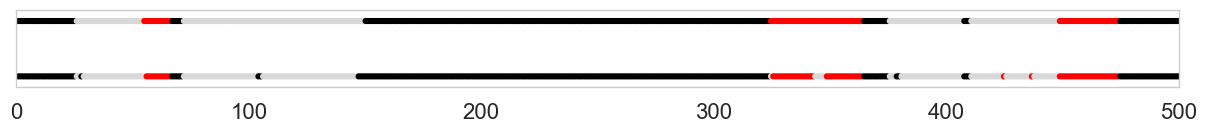

In [43]:
res = np.median(assignments_ar2[:,assignments_ar2.shape[1]*7//8:], axis=1).astype(np.int16)
seq2_updated, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

plt.figure(figsize=(15,1))
plt.scatter(np.linspace(0,len(res),num=len(res)), 1.5*np.ones_like(res), c=[c[i] for i in seq2_updated], lw=0)
plt.xlim([0,len(res)])
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(res)])

plt.yticks([])
plt.grid(False)

#### Inference with SLDS(2) Model

In [44]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

params = {}
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array(np.eye(D)), 'sigma': 1*np.eye(D)} for i in range(L)]
params['R'] = 1e-1*np.eye(D)
params['R0'] = 1e-1*np.eye(D)
params['r0'] = 1e1
params['C'] = np.eye(D)
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = .1*len(Y)
params['gamma'] = 1
params['priors'] = {
    'M': np.zeros(shape=(D,D)),
    'K': .1*np.eye(D)
}

params, z, assignments_slds,_ = hdp.SLDS_blocked_sampler(Y, params, priors=[np.cov(Y.T), D+2],
                                                  num_iter=100,
                                                  verbose=True,
                                                  return_assignments=True,
                                                  chains=chains,
                                                  Y_tilde = np.random.normal(0,1,size=(params['T'], D)).astype(np.float64))

Iteration: 0, # inf chain: 10, time: 1.70, hamming_dist: 425.000


/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py:406: RuntimeWarning: covariance is not positive-semidefinite.
  states[0] = np.random.multivariate_normal(mean=mean.reshape(-1,), cov=Sigma)
/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py:415: RuntimeWarning: covariance is not positive-semidefinite.
  states[t] = np.random.multivariate_normal(mean=mean.reshape(-1,), cov=Sigma)


Iteration: 10, # inf chain: 4, time: 1.67, hamming_dist: 209.000
Iteration: 20, # inf chain: 3, time: 1.58, hamming_dist: 208.000
Iteration: 30, # inf chain: 2, time: 1.58, hamming_dist: 201.000
Iteration: 40, # inf chain: 2, time: 1.58, hamming_dist: 237.000
Iteration: 50, # inf chain: 2, time: 1.57, hamming_dist: 267.000
Iteration: 60, # inf chain: 1, time: 1.63, hamming_dist: 255.000
Iteration: 70, # inf chain: 1, time: 1.62, hamming_dist: 255.000
Iteration: 80, # inf chain: 1, time: 1.63, hamming_dist: 255.000
Iteration: 90, # inf chain: 1, time: 1.67, hamming_dist: 255.000


#### Visualization of results

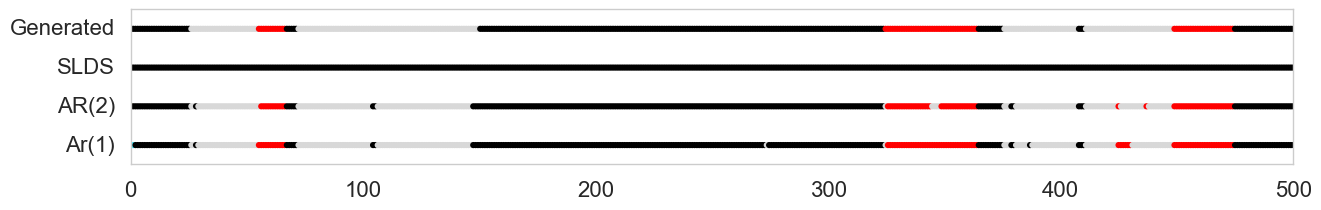

In [45]:
res = np.median(assignments_ar1[:,assignments_ar1.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar1, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_ar2[:,assignments_ar2.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar2, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_slds[:,assignments_slds.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_slds, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

##############################################

plt.figure(figsize=(15,2))

plt.scatter(np.linspace(0,len(res),num=len(res)), 0*np.ones_like(res), c=[c[i] for i in seq2_updated_ar1], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 1*np.ones_like(res), c=[c[i] for i in seq2_updated_ar2], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in seq2_updated_slds], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 3*np.ones_like(res), c=[c[i] for i in chains], lw=0)

plt.xlim([0,len(res)])

plt.yticks([0,1,2,3], ['Ar(1)', 'AR(2)', 'SLDS', 'Generated'])
plt.grid(False)

<a id=4></a>
# AR(2) Model

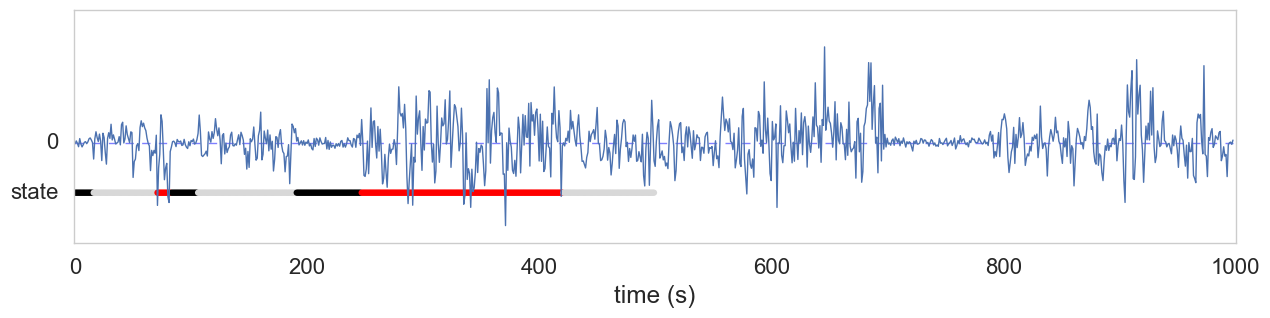

In [88]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

chain_params = [{"A": np.random.uniform(-0.5,0.5,size=2), "sigma": 1},
                {"A": np.random.uniform(-0.5,0.5,size=2), "sigma": 1},
                {"A": np.random.uniform(-0.5,0.5,size=2), "sigma": 2}]
length = 1000
res = gen.generate_data_1D(num_chains=len(chain_params), length=length, switch_prob=0.1, chain_params=chain_params, ar=2)
chains, Y = res['chains'][1:], res['Y'][1:,0]

fig, ax = plt.subplots(figsize=(15,3))

plt.scatter(temp, -7.5*np.ones_like(temp), c=[c[i] for i in chains], lw=0)
plt.plot(np.zeros_like(Y), lw=1, c='b', alpha=0.5, ls='--')
plt.plot(Y, lw=1)

plt.xlim([-1,length+1])
plt.grid(False)
plt.yticks([-7.5, 0], ['state','0'])
plt.xlabel('time (s)')

plt.show()

#### Run the inference

In [89]:
# AR(1)
params = {}
L = 10
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[np.random.normal(1,1)]]), 'sigma': np.array([[10]], dtype=np.float64)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 5
params['gamma'] = 1
params['priors'] = {
    'M': 1*np.zeros(shape=(D,D)),
    'K': 1*np.eye(D)
}

params, res, assignments_ar1, _ = hdp.sticky_HDP_AR(Y, params, priors=[1*np.eye(1), 10],
                                     num_iter=100,
                                     return_assignments=True,
                                     verbose=True,
                                     chains=chains)

Iteration: 0, # inf chain: 10, time: 2.68, hamming_dist: 861.000
Iteration: 10, # inf chain: 10, time: 2.49, hamming_dist: 713.000
Iteration: 20, # inf chain: 7, time: 2.53, hamming_dist: 446.000
Iteration: 30, # inf chain: 6, time: 2.50, hamming_dist: 163.000
Iteration: 40, # inf chain: 6, time: 2.52, hamming_dist: 118.000
Iteration: 50, # inf chain: 4, time: 2.58, hamming_dist: 143.000
Iteration: 60, # inf chain: 6, time: 2.50, hamming_dist: 122.000
Iteration: 70, # inf chain: 7, time: 2.59, hamming_dist: 83.000
Iteration: 80, # inf chain: 7, time: 2.52, hamming_dist: 159.000
Iteration: 90, # inf chain: 5, time: 2.60, hamming_dist: 132.000


In [90]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

# AR(2)
params = {}
D,L =1,10
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[[np.random.uniform(-1,1)]], [[np.random.uniform(-1,1)]]]), 'sigma': np.array([[1]])} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 5
params['gamma'] = 1
params['priors'] = {
    'M': np.zeros(shape=(D,D*2)),
    'K': 1*np.eye(D*2)
}

params, res, assignments_ar2, _ = hdp.sticky_Multi_HDP_AR2(Y, params, priors=[1*np.eye(D), 10],
                                     num_iter=100,
                                     return_assignments=True,
                                     verbose=True,
                                     chains=chains)

Iteration: 0, # inf chain: 10, time: 4.62, hamming_dist: 837.000


/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py:366: RuntimeWarning: covariance is not positive-semidefinite.
  A_ = np.random.multivariate_normal(mean=M.T.reshape(-1,), cov=np.kron(sig, K_inv)).astype(np.float32)


Iteration: 10, # inf chain: 10, time: 4.66, hamming_dist: 693.000
Iteration: 20, # inf chain: 7, time: 4.74, hamming_dist: 341.000
Iteration: 30, # inf chain: 6, time: 4.91, hamming_dist: 73.000
Iteration: 40, # inf chain: 4, time: 4.84, hamming_dist: 91.000
Iteration: 50, # inf chain: 5, time: 4.75, hamming_dist: 106.000
Iteration: 60, # inf chain: 4, time: 4.61, hamming_dist: 128.000
Iteration: 70, # inf chain: 4, time: 4.78, hamming_dist: 86.000
Iteration: 80, # inf chain: 4, time: 4.79, hamming_dist: 104.000
Iteration: 90, # inf chain: 5, time: 4.91, hamming_dist: 97.000


In [92]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

params = {}
D = 2
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.eye(2, dtype=np.float32), 'sigma': 1*np.eye(2, dtype=np.float32)} for i in range(L)]
params['R'] = 1*np.eye(1, dtype=np.float64)
params['R0'] = 1*np.eye(1, dtype=np.float64)
params['r0'] = 1e1
params['C'] = np.array([[1, 0]], dtype=np.float64)
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 5
params['gamma'] = 1
params['priors'] = {
    'M': np.zeros(shape=(D,D), dtype=np.float32),
    'K': 1*np.eye(D, dtype=np.float32),
}

params, z, assignments_slds, _ = hdp.SLDS_blocked_sampler(Y, params, priors=[1*np.eye(D), 1],
                                      num_iter=100,
                                      verbose=True,
                                      return_assignments=True,
                                      chains=chains,
                                      Y_tilde = np.random.normal(0,1,size=(params['T'], D)).astype(np.float32))

Iteration: 0, # inf chain: 10, time: 4.47, hamming_dist: 834.000


/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py:422: RuntimeWarning: covariance is not positive-semidefinite.
  states[0] = np.random.multivariate_normal(mean=mean.reshape(-1,), cov=Sigma)
/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py:431: RuntimeWarning: covariance is not positive-semidefinite.
  states[t] = np.random.multivariate_normal(mean=mean.reshape(-1,), cov=Sigma)
/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py:370: RuntimeWarning: covariance is not positive-semidefinite.
  A_ = np.random.multivariate_normal(mean=M.T.reshape(-1,), cov=np.kron(sig, K_inv)).astype(np.float32)


ValueError: Degrees of freedom cannot be less than dimension of scale matrix, but df = 1

#### Visualization of results

In [ ]:
res = np.median(assignments_ar1[:,assignments_ar1.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar1, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)
print('AR1: ', hamming_val)

res = np.median(assignments_ar2[:,assignments_ar2.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar2, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)
print('AR2: ', hamming_val)

res = np.median(assignments_slds[:,assignments_slds.shape[1]*3//4:], axis=1).astype(np.int16)
# res = assignments_slds[:,-1]
seq2_updated_slds, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)
print('SLDS: ', hamming_val)
##############################################

plt.figure(figsize=(15,2))

plt.scatter(np.linspace(0,len(res),num=len(res)), 0*np.ones_like(res), c=[c[i] for i in seq2_updated_ar1], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 1*np.ones_like(res), c=[c[i] for i in seq2_updated_ar2], lw=0)
# plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in assignments_ar2[:,-1].astype(np.int16)], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in seq2_updated_slds], lw=0)
# plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in assignments_slds[:,0].astype(np.int16)], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 3*np.ones_like(res), c=[c[i] for i in chains], lw=0)

plt.xlim([0,len(res)])

plt.yticks([0,1,2,3], ['Ar(1)', 'AR(2)', 'SLDS', 'Generated'])
plt.grid(False)

<a id=5></a>
# SLDS Model

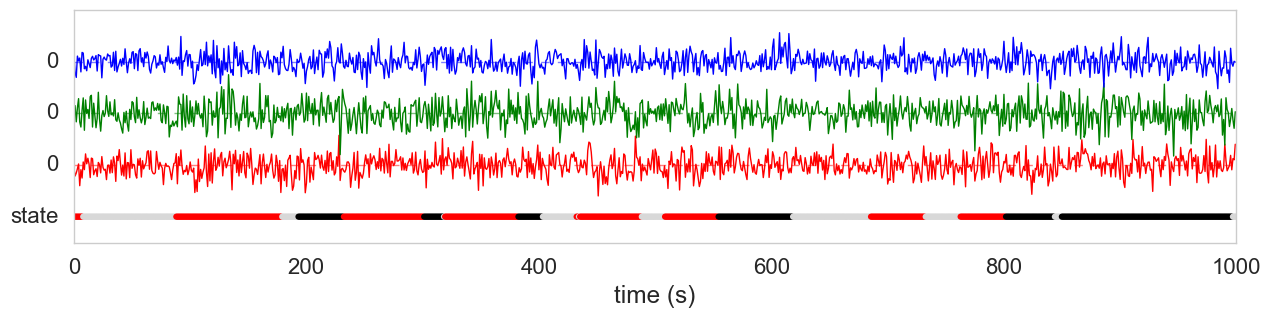

In [17]:
Y = np.array([0,0,0]) # there are three observables
dim = 3

length = 1000
chain_params = [{"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)), 5, 5)}, 
                {"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)), 1, 5)}, 
                {"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)), 3, 5)}]

R = generateCovMatrix(dim, 0, 3, 5)
res = gen.generate_data_slsd(dim=3, R=R, num_chains=len(chain_params), length=length, switch_prob=0.1, chain_params=chain_params)
chains, Y = res['chains'], res['Y']
    
plt.figure(figsize=(15,3))

plt.plot(Y[:,0], lw=1, c='r')
plt.plot(np.ones_like(Y[:,0])*0, lw=1, c='r', alpha=0.5, ls='--')
plt.plot(Y[:,1] + 10, lw=1, c='g')
plt.plot(np.ones_like(Y[:,0])*10, lw=1, c='g', alpha=0.5, ls='--')
plt.plot(Y[:,2] + 20, lw=1, c='b')
plt.plot(np.ones_like(Y[:,0])*20, lw=1, c='b', alpha=0.5, ls='--')

plt.scatter(np.linspace(0,len(chains),num=len(chains)), -10*np.ones_like(chains), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(chains)])
plt.yticks([-10,0,10,20],('state','0','0','0'))
plt.xlabel('time (s)')

plt.grid(False)

In [18]:
params = {}

L,D=10,3
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array(np.eye(D))*np.random.normal(0,1,size=D), 'sigma': 1*np.eye(D)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 5
params['gamma'] = 1
params['priors'] = {
    'M': np.zeros(shape=(D,D)),
    'K': 1*np.eye(D)
}

params, res, assignments_ar1,har1 = hdp.sticky_Multi_HDP_AR(Y, params, priors=[1*np.eye(D), D],
                                             num_iter=100,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

Iteration: 0, # inf chain: 10, time: 4.93, hamming_dist: 851.000
Iteration: 10, # inf chain: 9, time: 4.52, hamming_dist: 775.000
Iteration: 20, # inf chain: 8, time: 4.45, hamming_dist: 766.000
Iteration: 30, # inf chain: 7, time: 4.44, hamming_dist: 783.000
Iteration: 40, # inf chain: 6, time: 4.46, hamming_dist: 730.000
Iteration: 50, # inf chain: 4, time: 4.47, hamming_dist: 751.000
Iteration: 60, # inf chain: 4, time: 4.44, hamming_dist: 431.000
Iteration: 70, # inf chain: 4, time: 5.04, hamming_dist: 423.000
Iteration: 80, # inf chain: 3, time: 4.83, hamming_dist: 725.000
Iteration: 90, # inf chain: 3, time: 5.07, hamming_dist: 675.000


In [19]:
params = {}
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([stats.matrix_normal(mean=np.eye(D)).rvs(),
                                   stats.matrix_normal(mean=np.eye(D)).rvs()]), 
                    'sigma': np.random.gamma(1,10)*np.array(np.eye(D))} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 5
params['gamma'] = 1
params['priors'] = {
    # need to adjust the priors slightly
    'M': np.concatenate([np.array(np.eye(D)), np.array(np.eye(D))], axis=1),
    'K': 1*np.eye(D*2)
}

params, res, assignments_ar2,har2 = hdp.sticky_Multi_HDP_AR2(Y, params, priors=[1*np.eye(D), D],
                                             num_iter=100,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

Iteration: 0, # inf chain: 10, time: 4.72, hamming_dist: 876.000
Iteration: 10, # inf chain: 6, time: 5.29, hamming_dist: 728.000
Iteration: 20, # inf chain: 5, time: 5.12, hamming_dist: 724.000
Iteration: 30, # inf chain: 5, time: 5.34, hamming_dist: 644.000
Iteration: 40, # inf chain: 3, time: 4.82, hamming_dist: 632.000
Iteration: 50, # inf chain: 3, time: 5.06, hamming_dist: 657.000
Iteration: 60, # inf chain: 3, time: 5.10, hamming_dist: 630.000
Iteration: 70, # inf chain: 3, time: 4.77, hamming_dist: 616.000
Iteration: 80, # inf chain: 3, time: 4.98, hamming_dist: 584.000
Iteration: 90, # inf chain: 2, time: 5.02, hamming_dist: 583.000


In [20]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

params = {}
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': stats.matrix_normal(mean=np.eye(D)).rvs(), 'sigma': 1*np.eye(D)} for i in range(L)]
params['R'] = 1*np.eye(D)
params['R0'] = 1*np.eye(D)
params['r0'] = 1e1
params['C'] = np.eye(D)
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/10
params['gamma'] = 1
params['priors'] = {
    'M': np.zeros(shape=(D,D)),
    'K': 1*np.eye(D)
}

params, z, assignments_slds,hslds = hdp.SLDS_blocked_sampler(Y, params, priors=[1*np.eye(D), D],
                                                  num_iter=250,
                                                  verbose=True,
                                                  return_assignments=True,
                                                  chains=chains,
                                                  Y_tilde = np.random.normal(0,1,size=(params['T'], D)).astype(np.float64))

Iteration: 0, # inf chain: 10, time: 4.81, hamming_dist: 783.000
Iteration: 10, # inf chain: 8, time: 5.15, hamming_dist: 666.000
Iteration: 20, # inf chain: 6, time: 5.10, hamming_dist: 861.000
Iteration: 30, # inf chain: 5, time: 5.12, hamming_dist: 579.000
Iteration: 40, # inf chain: 5, time: 4.73, hamming_dist: 554.000
Iteration: 50, # inf chain: 4, time: 5.20, hamming_dist: 682.000
Iteration: 60, # inf chain: 4, time: 5.04, hamming_dist: 611.000
Iteration: 70, # inf chain: 4, time: 5.21, hamming_dist: 557.000
Iteration: 80, # inf chain: 4, time: 5.08, hamming_dist: 586.000
Iteration: 90, # inf chain: 4, time: 5.03, hamming_dist: 564.000
Iteration: 100, # inf chain: 4, time: 5.00, hamming_dist: 563.000
Iteration: 110, # inf chain: 4, time: 5.08, hamming_dist: 528.000
Iteration: 120, # inf chain: 4, time: 5.21, hamming_dist: 542.000
Iteration: 130, # inf chain: 4, time: 4.89, hamming_dist: 565.000
Iteration: 140, # inf chain: 4, time: 5.14, hamming_dist: 686.000
Iteration: 150, # in

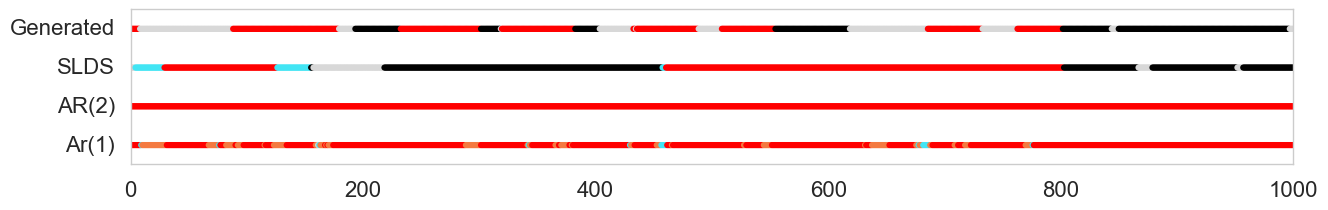

In [21]:
res = np.median(assignments_ar1[:,assignments_ar1.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar1, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_ar2[:,assignments_ar2.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar2, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_slds[:,assignments_slds.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_slds, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

##############################################

plt.figure(figsize=(15,2))

plt.scatter(np.linspace(0,len(res),num=len(res)), 0*np.ones_like(res), c=[c[i] for i in seq2_updated_ar1], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 1*np.ones_like(res), c=[c[i] for i in seq2_updated_ar2], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in seq2_updated_slds], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 3*np.ones_like(res), c=[c[i] for i in chains], lw=0)

plt.xlim([0,len(res)])

plt.yticks([0,1,2,3], ['Ar(1)', 'AR(2)', 'SLDS', 'Generated'])
plt.grid(False)

<hr />
<hr />